# Grabcut Background Removal

---
### Imports and Helper-functions

In [1]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
def imshow(img, title=None, size=10, axis=False, color_space="BGR"):
    aspect_ratio = img.shape[0] / img.shape[1]
    plt.figure(figsize=(size * aspect_ratio, size))
    if color_space.lower() == "bgr":
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_space.lower() == "rgb":
        rgb_img = img
    else:
        rgb_img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(rgb_img)
    if type(title) == str:
        plt.title(title)
    if axis == False:
        plt.axis('off')
    plt.show()

In [3]:
def get_random_img_path(search_path='../../res/img', skip=["flickr"]):
    """
    This function searches for common image files in all subdirectories
    and return a random image path of them.
    """
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.ico']
    image_paths = []

    # Walk through all subdirectories
    for root, dirs, files in os.walk(search_path):
        for file_name in files:
            # Check if the file is an image
            if any(file_name.lower().endswith(ext) for ext in image_extensions):
                # Get the full file path
                full_path = os.path.join(root, file_name).replace("\\", "/")
                if not any(i in full_path for i in skip):
                    image_paths.append(full_path)

    return random.choice(image_paths)

# get an image
IMG_PATH = "../../res/img/self/apes-5.jpg"
IMG_PATH   

'../../res/img/self/apes-5.jpg'

---
### Loading data

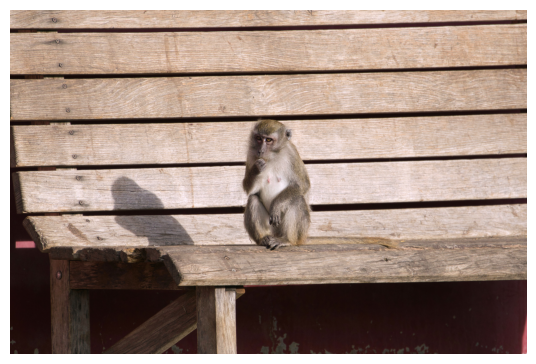

(3597, 5396, 3)

In [4]:
img = cv2.imread(IMG_PATH)
imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img.shape

---
### GrabCut

- **User inputs the rectangle**. Everything outside this rectangle will be taken as the background. Everything inside rectangle is unknown. 
- The algorithm labels the foreground and background pixels (or it hard-labels)
- Next a Gaussian Mixture Model(GMM) is used to model the foreground and background.
- Depending on the data we gave, GMM learns and create new pixel distribution. That is, the **unknown pixels are labelled either probable foreground or probable background** depending on its relation with the other hard-labelled pixels in terms of color statistics (It is just like clustering).
- A graph is built from this pixel distribution. Nodes in the graphs are pixels. Additional two nodes are added, Source node and Sink node. Every foreground pixel is connected to Source node and every background pixel is connected to Sink node.
- The weights of edges connecting pixels to source node/end node are defined by the probability of a pixel being foreground/background. The weights between the pixels are defined by the edge information or pixel similarity. If there is a large difference in pixel color, the edge between them will get a low weight.
= Then a mincut algorithm is used to segment the graph. It cuts the graph into two separating source node and sink node with minimum cost function. The cost function is the sum of all weights of the edges that are cut. After the cut, all the pixels connected to Source node become foreground and those connected to Sink node become background.
- The process is continued until the classification converges.

![](https://docs.opencv.org/3.4/grabcut_scheme.jpg)

Paper - http://dl.acm.org/citation.cfm?id=1015720

Learn more - https://docs.opencv.org/3.4/d8/d83/tutorial_py_grabcut.html

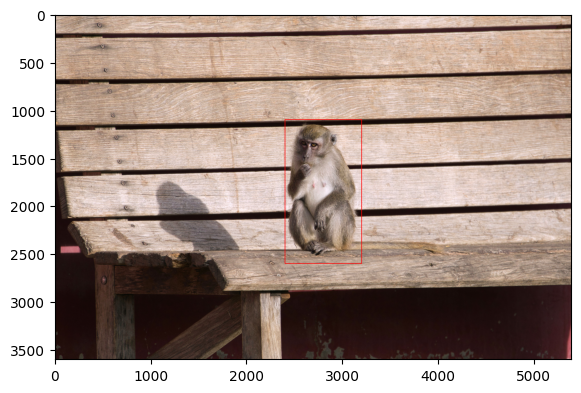

In [10]:
copy = img.copy()

# Create a mask (of zeros uint8 datatype) that is the same size (width, height) as our original image 
mask = np.zeros(copy.shape[:2], np.uint8)

bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

# Needs to be set Manually or selected with cv2.selectROI()
x1, y1, x2, y2 = 2400, 1100, 3200, 2600
start = (x1, y1)
end = (x2, y2)

# Format is X,Y,W,H
rect = (x1, y1, x2-x1, y2-y1)

# Show Rectangle
cv2.rectangle(copy, start, end, (0, 0, 255), 5)
imshow(copy, axis=True)

---
### Grabcut Arguments

- **img** - Input image
- **mask** - It is a mask image where we specify which areas are background, foreground or probable background/foreground etc. It is done by the following flags, cv.GC_BGD, cv.GC_FGD, cv.GC_PR_BGD, cv.GC_PR_FGD, or simply pass 0,1,2,3 to image.
- **rec**t - It is the coordinates of a rectangle which includes the foreground object in the format (x,y,w,h)
- **bdgModel, fgdModel** - These are arrays used by the algorithm internally. You just create two np.float64 type zero arrays of size (1,65).
- **iterCount** - Number of iterations the algorithm should run.
- **mode** - It should be cv.GC_INIT_WITH_RECT or cv.GC_INIT_WITH_MASK or combined which decides whether we are drawing rectangle or final touchup strokes.

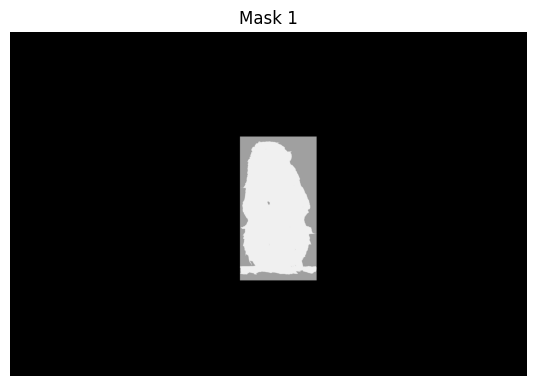

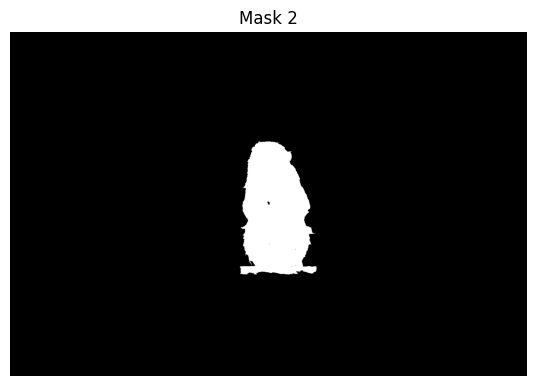

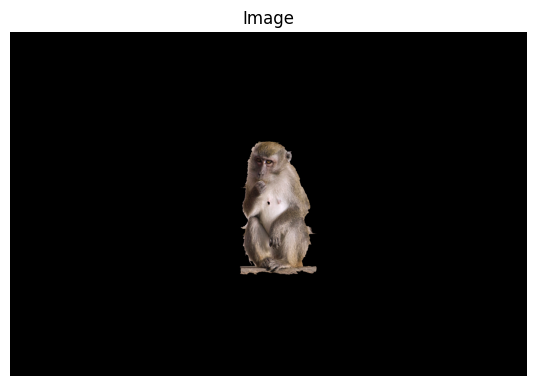

In [13]:
# Let the algorithm run for 5 iterations. Mode should be cv.GC_INIT_WITH_RECT since we are using rectangle. 
# Grabcut modifies the mask image. 
# In the new mask image, pixels will be marked with four flags denoting background/foreground as specified above. 
# So we modify the mask such that all 0-pixels and 2-pixels are put to 0 (i.e. background) & all 1-pixels and 3-pixels are put to 1(i.e. foreground pixels). 
# Now our final mask is ready. Just multiply it with input image to get the segmented image.
cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img * mask2[:,:,np.newaxis]

imshow(mask * 80, "Mask 1")
imshow(mask2 * 255, "Mask 2")
imshow(img, "Image")

---